<a href="https://colab.research.google.com/github/kundajelab/adar_editing/blob/master/xgboost_with_shap/TTYH2_XGBOOST_WITH_TREESHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:

## Uncomment these lines if running as a google colab notebook: 
#!pip install numpy==1.15
#! git clone https://github.com/kundajelab/adar_editing
#import os
#os.chdir("adar_editing/xgboost_with_shap/")
#!pip install shap
#!pip install --upgrade xgboost
#!pip install cufflinks
 

In [6]:
%load_ext autoreload
%autoreload 2  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [8]:
#helper utilities for model training and interpretation 
import shap
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import chart_studio.plotly as plotly
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap

import feature_subsets
import xgboost


## Neil1 xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#1>Degenerate Dataset</a></li>
    <li><a href=#2>Degenerate Dataset: Feature Subsets</a></li>
    <li><a href=#3>Computational Dataset</a></li>
    <li><a href=#4>Computational Dataset Feature Subsets</a></li>
    <li><a href=#5>Exclude mut features</a></li>
 </ol>


## TTYH2 Computational features <a name='3'>
<a href=#outline>Home</a>

In [10]:
import pandas as pd 
import xgboost 

In [11]:
data=pd.read_csv("../xin_feature_matrices/ttyh2_computational.features.csv",header=0,sep=',',index_col=0)

In [12]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [13]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(601, 205)
{21.0: 18, 22.0: 18, 23.0: 18, 24.0: 20, 25.0: 17, 26.0: 20, 27.0: 20, 28.0: 20, 29.0: 18, 30.0: 18, 31.0: 17, 32.0: 17, 33.0: 17, 34.0: 18, 35.0: 18, 36.0: 18, 79.0: 17, 80.0: 17, 81.0: 18, 82.0: 18, 83.0: 19, 84.0: 19, 85.0: 20, 86.0: 29, 88.0: 27, 89.0: 18, 90.0: 17, 91.0: 17, 92.0: 17, 93.0: 14, 94.0: 18, 95.0: 18, nan: 0, nan: 0, nan: 0, nan: 0, nan: 6}


In [14]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [15]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [16]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

site_3prm_cp_bulge:C:G
d3_length_internal_ecs
u2_3prm_cp_internal:A:U
d1_length_internal_ecs
site_next_nt:A
d1_length_bulge
d2_5prm_cp_internal:U:G
d3_length_internal_es
site_prev_nt:A
u2_5prm_cp_bulge:G:U
site_next_nt:U
d3_5prm_cp_hairpin
u1_3prm_cp_internal:G:U
u1_length_hairpin
u3_length_bulge
u2_3prm_cp_bulge:U:G
site_5prm_cp_bulge:G:C
site_5prm_cp_bulge:U:G
u_hairpin_length
mut_type:mismatch
d1_length_internal_es
mut_exist
u2_5prm_cp_internal:C:G
d3_3prm_cp_internal
d3_5prm_cp_internal
d1_struct:I
site_length_hairpin
u2_3prm_cp_bulge:G:C
d2_5prm_cp_bulge:A:U
d2_length_stem
u1_struct:I
u1_5prm_cp_hairpin
site_next_struct:I
d3_3prm_cp_bulge:G:C
u3_length_internal_es
mut_same_as_site
u3_5prm_cp_internal
d1_5prm_cp_bulge
site_5prm_cp_hairpin
u1_length_bulge
u2_3prm_cp_internal:U:A
d1_5prm_cp_internal:C:G
d3_length_hairpin
u3_3prm_cp_internal
u1_5prm_cp_internal:U:A
mut_type:wt
u1_length_internal_ecs
mut_ref_nt:U
d1_3prm_cp_bulge
d2_struct:S
mut_next_struct:E
d3_struct:B
site_3prm_cp_i

In [17]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [18]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [19]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(409, 115)
(409,)
(105, 115)
(105,)
(93, 115)
(93,)


In [20]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [21]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [22]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [23]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.69870	eval-mae:0.27739	eval-map:1.00000	eval-aucpr:0.21514	eval-rmse:0.29411	train-auc:0.71092	train-mae:0.22991	train-map:1.00000	train-aucpr:0.34649	train-rmse:0.25265
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.75835	eval-mae:0.20726	eval-map:1.00000	eval-aucpr:0.24709	eval-rmse:0.22032	train-auc:0.73931	train-mae:0.16432	train-map:1.00000	train-aucpr:0.35701	train-rmse:0.18338
[2]	eval-auc:0.77755	eval-mae:0.15008	eval-map:1.00000	eval-aucpr:0.25492	eval-rmse:0.16229	train-auc:0.74955	train-mae:0.11937	train-map:1.00000	train-aucpr:0.36203	train-rmse:0.13484
[3]	eval-auc:0.78297	eval-mae:0.11017	eval-map:1.00000	eval-aucpr:0.25544	eval-rmse:0.12126	train-auc:0.75290	train-mae:0.08743	train-map:1.00000	train-aucpr:0.36343	train-rmse:0.10067
[4]	eval-auc:0.78321	eval-mae:0.08506	eval-map:1.00000	eval-aucpr:0.25633	eval-rmse:0.09447	train-auc:0.75682	train

[44]	eval-auc:0.77848	eval-mae:0.03035	eval-map:1.00000	eval-aucpr:0.25571	eval-rmse:0.05226	train-auc:0.76685	train-mae:0.00449	train-map:1.00000	train-aucpr:0.37512	train-rmse:0.00636
[45]	eval-auc:0.77833	eval-mae:0.03032	eval-map:1.00000	eval-aucpr:0.25549	eval-rmse:0.05226	train-auc:0.76686	train-mae:0.00435	train-map:1.00000	train-aucpr:0.37514	train-rmse:0.00620
[46]	eval-auc:0.77842	eval-mae:0.03020	eval-map:1.00000	eval-aucpr:0.25553	eval-rmse:0.05223	train-auc:0.76688	train-mae:0.00414	train-map:1.00000	train-aucpr:0.37517	train-rmse:0.00584
[47]	eval-auc:0.77842	eval-mae:0.03015	eval-map:1.00000	eval-aucpr:0.25553	eval-rmse:0.05225	train-auc:0.76689	train-mae:0.00400	train-map:1.00000	train-aucpr:0.37517	train-rmse:0.00559
[48]	eval-auc:0.77799	eval-mae:0.03019	eval-map:1.00000	eval-aucpr:0.25521	eval-rmse:0.05242	train-auc:0.76690	train-mae:0.00387	train-map:1.00000	train-aucpr:0.37519	train-rmse:0.00540
[49]	eval-auc:0.77811	eval-mae:0.03040	eval-map:1.00000	eval-aucpr:0.2

[89]	eval-auc:0.77787	eval-mae:0.03037	eval-map:1.00000	eval-aucpr:0.25512	eval-rmse:0.05348	train-auc:0.76708	train-mae:0.00118	train-map:1.00000	train-aucpr:0.37536	train-rmse:0.00170
[90]	eval-auc:0.77787	eval-mae:0.03037	eval-map:1.00000	eval-aucpr:0.25512	eval-rmse:0.05348	train-auc:0.76708	train-mae:0.00118	train-map:1.00000	train-aucpr:0.37536	train-rmse:0.00170
[91]	eval-auc:0.77787	eval-mae:0.03037	eval-map:1.00000	eval-aucpr:0.25512	eval-rmse:0.05348	train-auc:0.76708	train-mae:0.00118	train-map:1.00000	train-aucpr:0.37536	train-rmse:0.00170
[92]	eval-auc:0.77787	eval-mae:0.03037	eval-map:1.00000	eval-aucpr:0.25512	eval-rmse:0.05348	train-auc:0.76708	train-mae:0.00118	train-map:1.00000	train-aucpr:0.37536	train-rmse:0.00170
[93]	eval-auc:0.77787	eval-mae:0.03037	eval-map:1.00000	eval-aucpr:0.25512	eval-rmse:0.05348	train-auc:0.76708	train-mae:0.00118	train-map:1.00000	train-aucpr:0.37536	train-rmse:0.00170
[94]	eval-auc:0.77787	eval-mae:0.03037	eval-map:1.00000	eval-aucpr:0.2

In [24]:
# save to binary file for faster loading
bst.save_model('ttyh2.computational.model')
# save model to text file 
bst.dump_model('ttyh2.computational.raw.txt')


In [25]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [26]:
## Get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred,
                                  positive_thresh=0.2)

Train
	Spearman corr : SpearmanrResult(correlation=0.9997602771206705, pvalue=0.0)
	Pearson corr : (0.9999256385828592, 0.0)
	MAE : 0.0011810536847808757
	MAPE : 0.01491881349358654
	RMSE : 0.0017019367566884756
	auPRC : 0.9999715553532826
	auROC : 0.9999759117406176
Eval
	Spearman corr : SpearmanrResult(correlation=0.9136846384192102, pvalue=4.546920020091627e-42)
	Pearson corr : (0.8814802361737365, 2.426795250040074e-35)
	MAE : 0.03037004603765173
	MAPE : 0.5069330364740846
	RMSE : 0.05347825660671856
	auPRC : 0.8948825988822086
	auROC : 0.9482758620689655
Test
	Spearman corr : SpearmanrResult(correlation=0.9069896732758953, pvalue=6.118436280924515e-36)
	Pearson corr : (0.8884804541722128, 1.545004521391928e-32)
	MAE : 0.027010718399478547
	MAPE : 0.3465354715454621
	RMSE : 0.05055931125002425
	auPRC : 0.905693903193374
	auROC : 0.971190781049936


In [27]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9997602771206705, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.9136846384192102, pvalue=4.546920020091627e-42)
Test:SpearmanrResult(correlation=0.9069896732758953, pvalue=6.118436280924515e-36)


Pearson correlation:
Train:(0.9999256385828592, 0.0)
Eval:(0.8814802361737365, 2.426795250040074e-35)
Test:(0.8884804541722128, 1.545004521391928e-32)


In [28]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0011810536847808757
MAE Eval:0.03037004603765173
MAE Test:0.027010718399478547


In [29]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:1.491881349358654%
MAPE Eval:50.69330364740846%
MAPE Test:34.65354715454621%


In [30]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0017019367566884756
RMSE Eval:0.05347825660671856
RMSE Test:0.05055931125002425


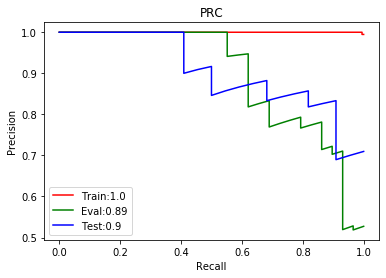

In [31]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.2 are labeled as "0". 
## Editing levels >= 0.2 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.2,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.2,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.2,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

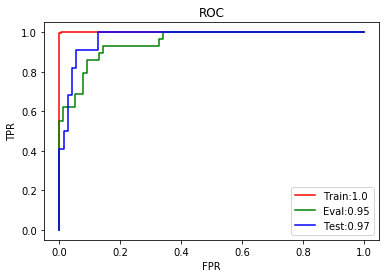

In [32]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.2,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.2,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.2,test_pred)

auroc_train=roc_auc_score(train_y>=0.2,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.2,eval_pred)
auroc_test=roc_auc_score(test_y>=0.2,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

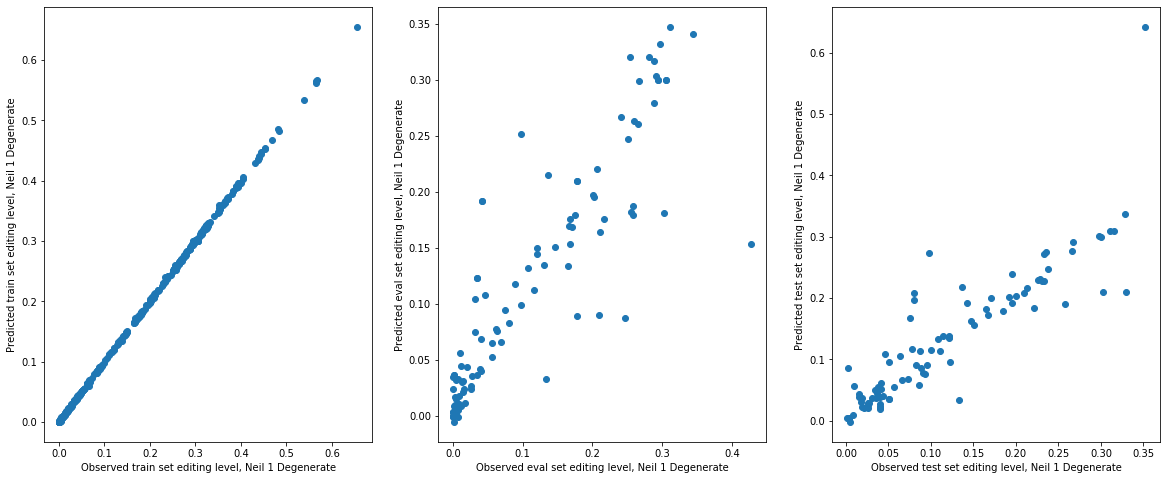

In [33]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

In [34]:
import plotnine
from plotnine import *
test_df=pd.DataFrame({'Observed':test_y,
                     'Predicted':test_pred,
                     'Dataset':'TTYH2_COMP'})

In [35]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals = test_y - test_pred

y_test_mean = np.mean(test_pred)
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y-y_test_mean)*(test_y-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.13066967
0.8720807010838181
0.23773068772914516
The R-square of the test data is  0.727 



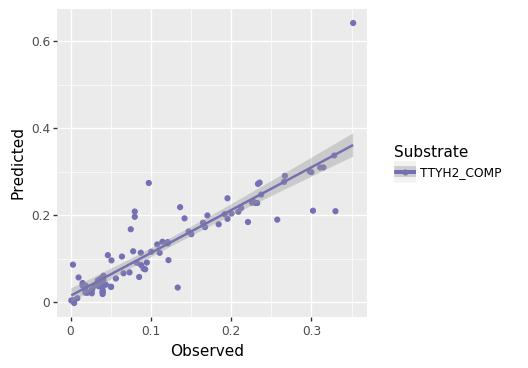

<ggplot: (8765718230057)>


In [36]:
plotnine.options.figure_size = (4, 4)

p=(ggplot(test_df, aes('Observed', 'Predicted', color='factor(Dataset)'))
 + geom_point()
 + stat_smooth(method='lm')
 + scale_color_manual(values=['#7570b3'],name="Substrate"))
print(p)
ggsave(plot=p, filename='TTYH2.comp.substrate.svg',width=4,height=4,units='in')


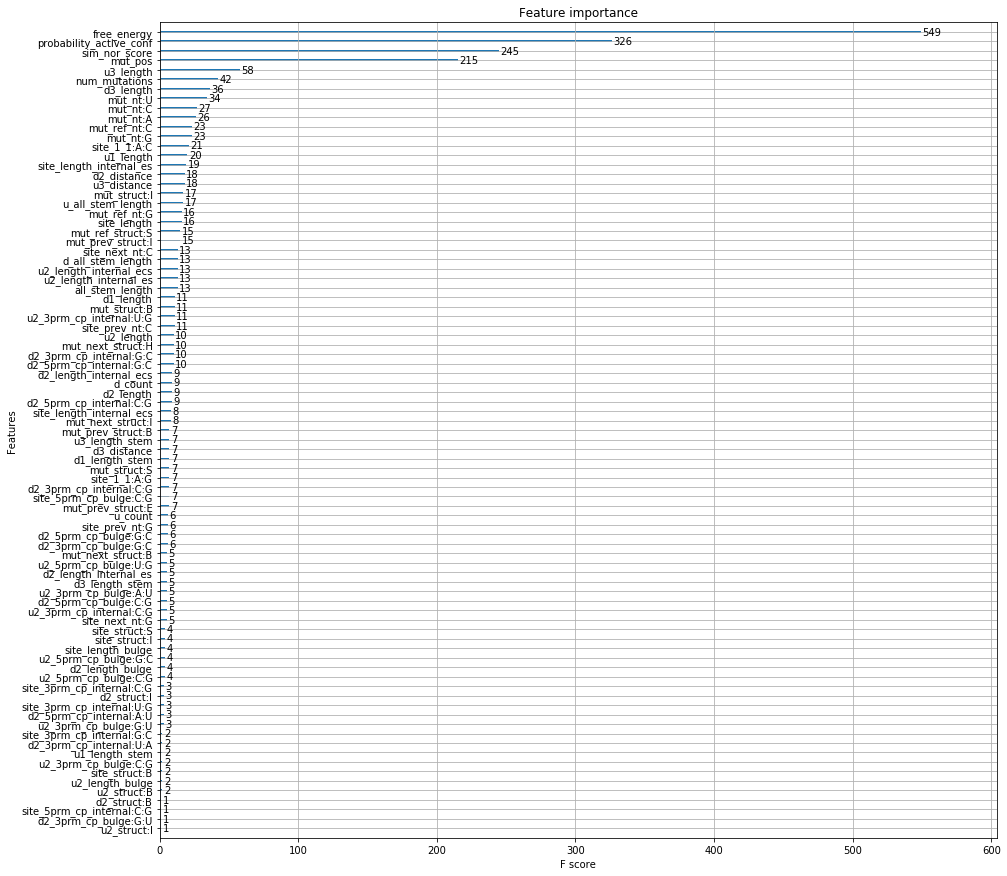

In [37]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

In [38]:
xgboost.to_graphviz(bst, num_trees=2)


ImportError: You must install graphviz to plot tree

In [42]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(93, 115)

In [43]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [44]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [45]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

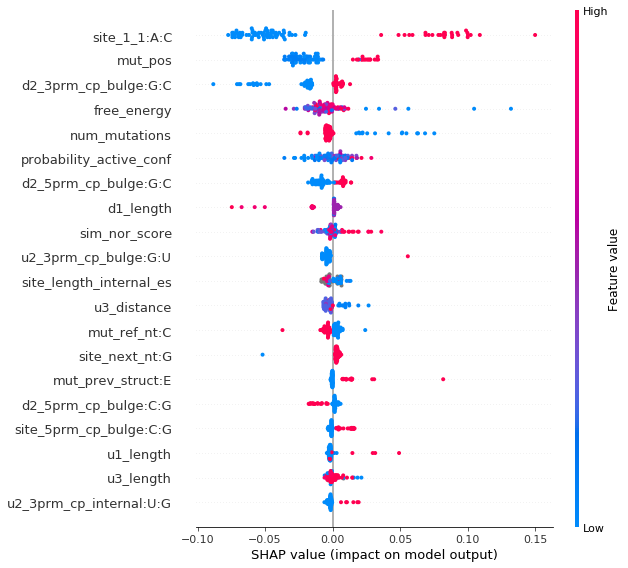

In [46]:
## summarize the effect of all the features 
shap.summary_plot(shap_values, test_X,show=False)
plt.savefig("TTYH2.comp.shap.svg", format='svg',width=30,height=10,dpi=300,bbox_inches="tight")
# summarize the effect of all the features 
#shap.summary_plot(shap_values, test_X,show=True)
#plt.gca().set_facecolor('white')
#plt.gca().set_axisbelow(True)
#plt.gca().grid(linestyle='-', linewidth='0.5', color='#eeeeee')

#plt.gcf().set_size_inches(5, 10)

#plt.savefig("TTYH2.comp.shap.svg", format='svg',width=20,height=10,dpi=300,bbox_inches="tight")


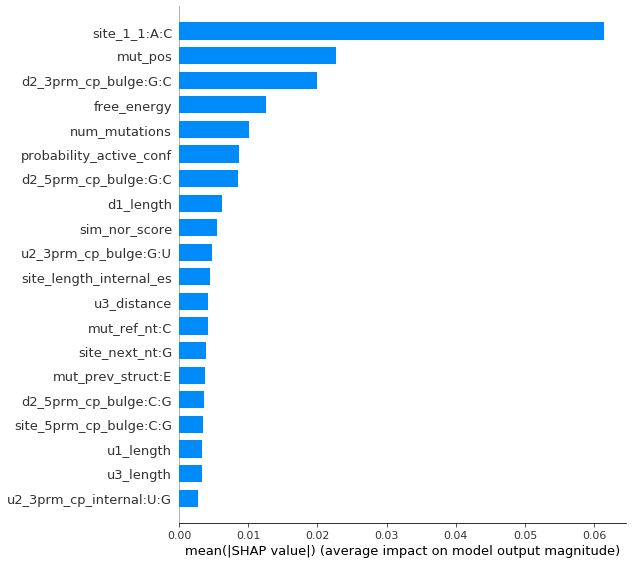

In [47]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [48]:
mean_abs_shap_vals=np.mean(abs(shap_values),axis=0)
features=test_X.columns
shap_dict=pd.DataFrame({'feature':features,
          'mean_abs_shap':mean_abs_shap_vals})
shap_dict.to_csv("TTYH2_comp_shap_mean_abs.txt",index=False,sep='\t')

In [49]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(93, 115, 115)

In [50]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [51]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [52]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)


## Computational Dataset: Feature Subsets<a name='4'>
<a href=#outline>Home</a>

In [53]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

['site_prev_nt*', 'site_next_nt*']


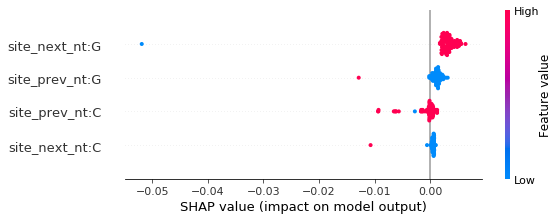

Contribution/Total:0.029095966
['free_energy*', 'sim_nor_score*', 'probability_active_conf*']


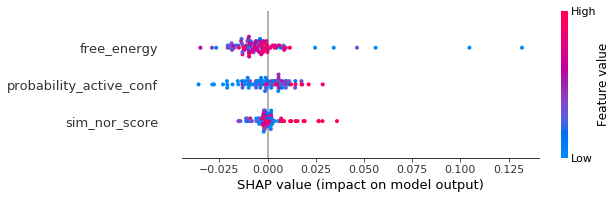

Contribution/Total:0.11178501
['u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*']


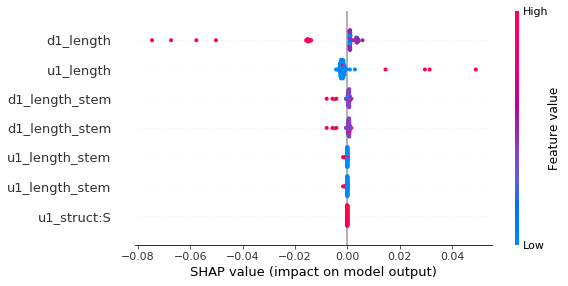

Contribution/Total:0.046616122
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


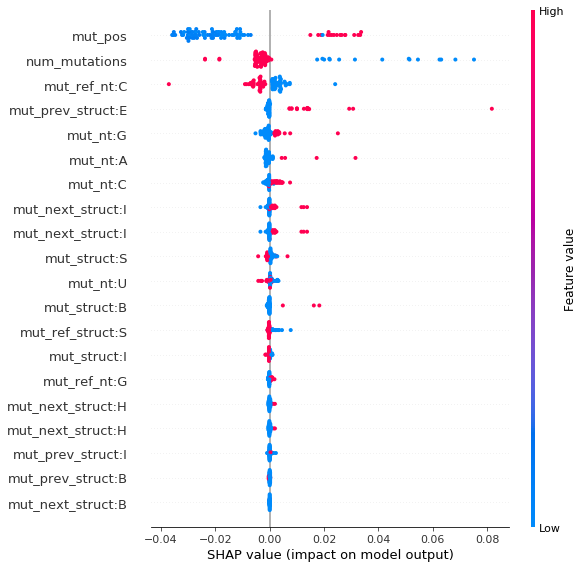

Contribution/Total:0.21554059
['site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


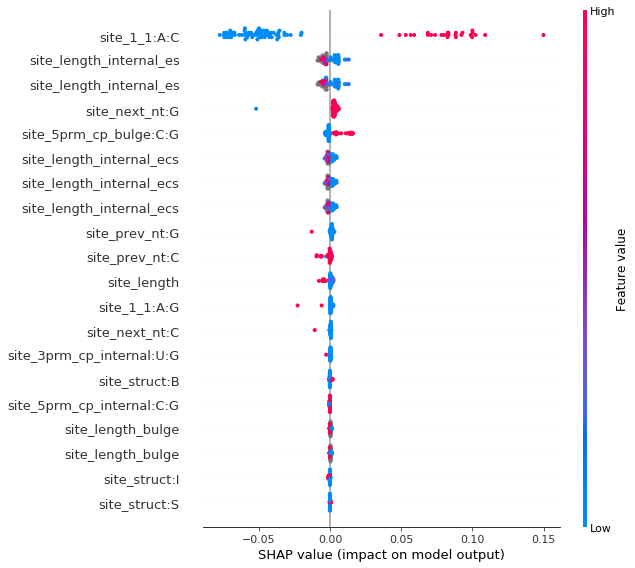

Contribution/Total:0.37566367
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*']


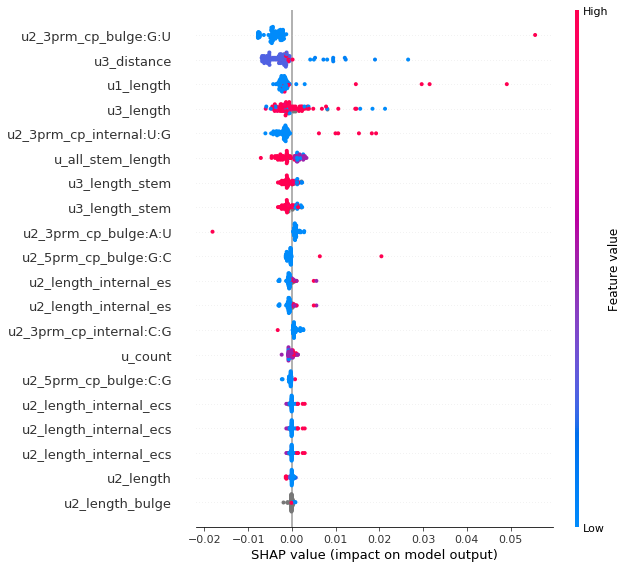

Contribution/Total:0.12295596
['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_internal_es*', 'd2_length_internal_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_internal*', 'd2_3prm_cp_internal*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_internal_es*', 'd3_length_internal_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_internal*', 'd3_3prm_cp_internal*']


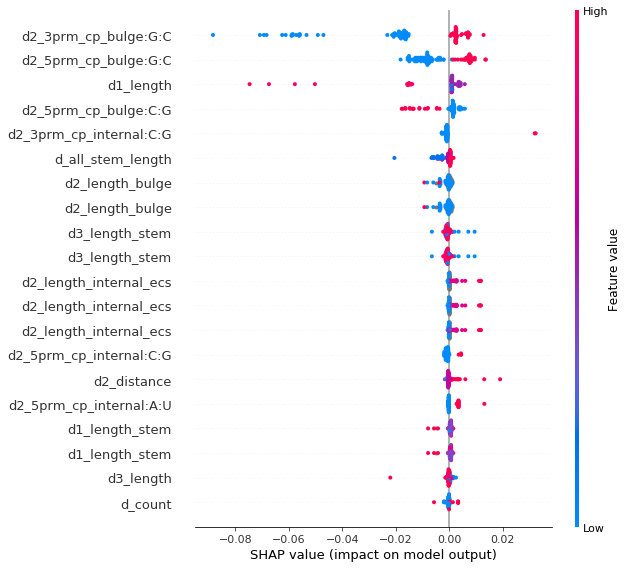

Contribution/Total:0.23892452
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*',

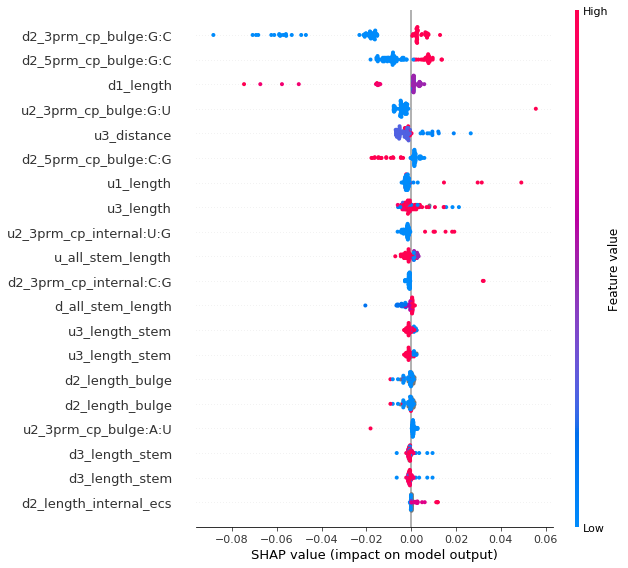

Contribution/Total:0.36188048
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


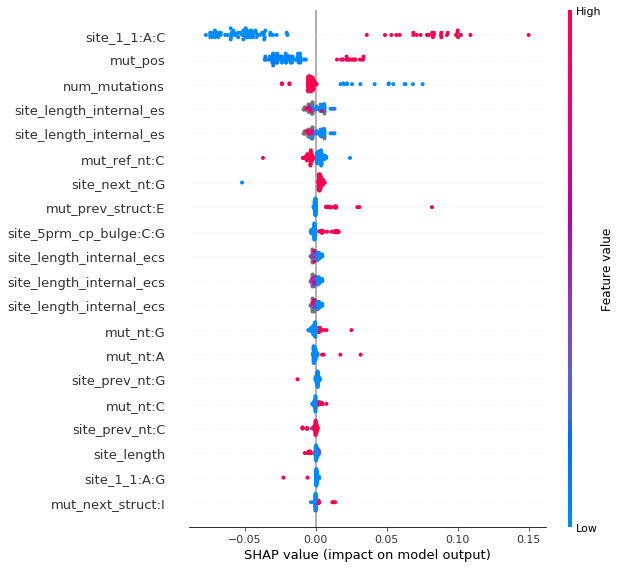

Contribution/Total:0.5912043
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_s

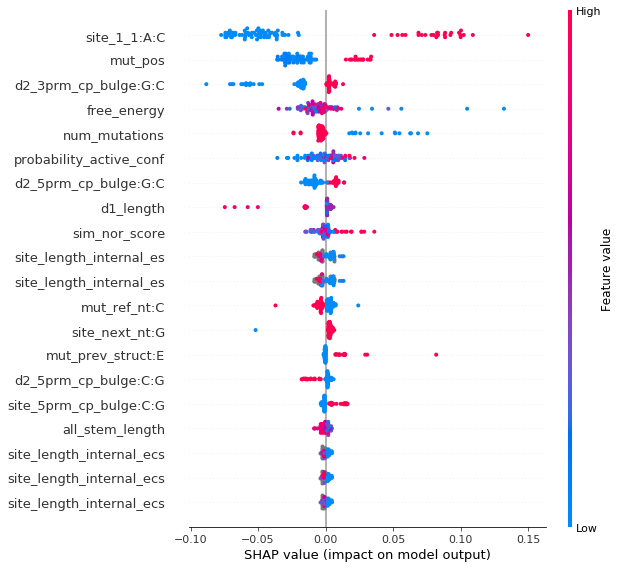

Contribution/Total:0.96557933
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*',

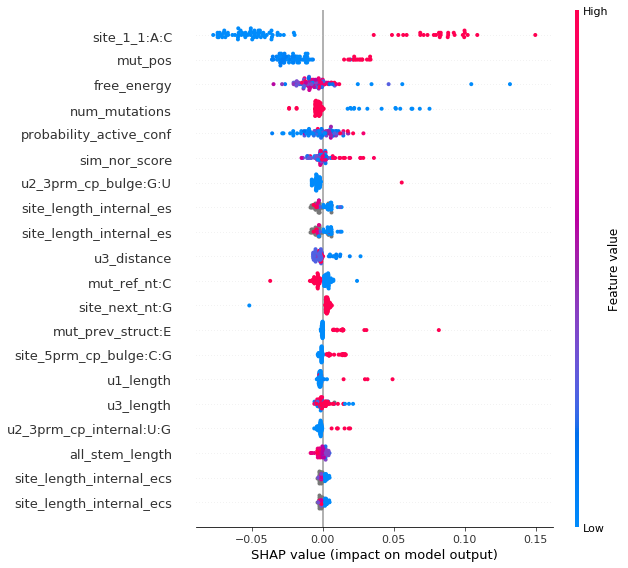

Contribution/Total:0.84961075
['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


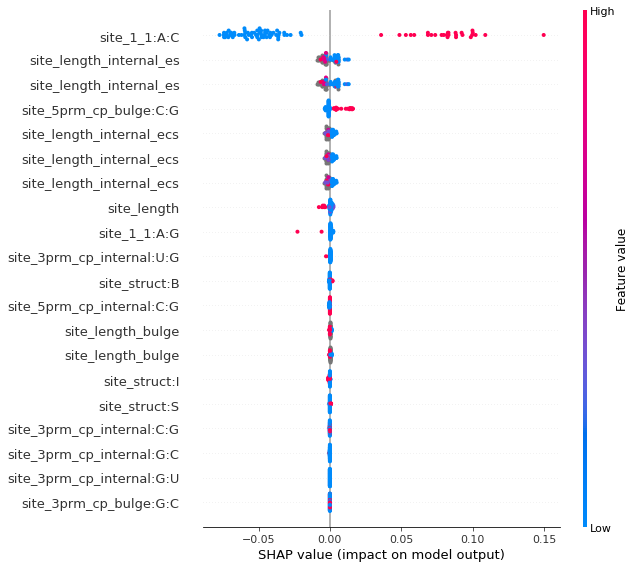

Contribution/Total:0.34656775
['site_prev_nt*', 'site_next_nt*']


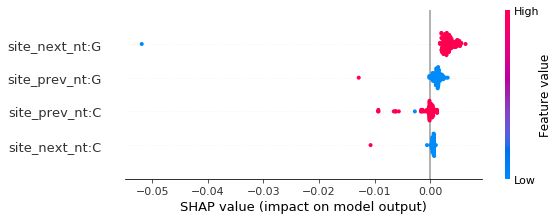

Contribution/Total:0.029095966
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


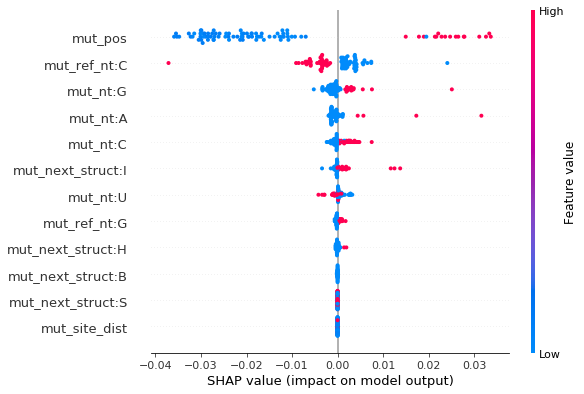

Contribution/Total:0.1413894
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'site_prev_nt*', 'site_next_nt*']


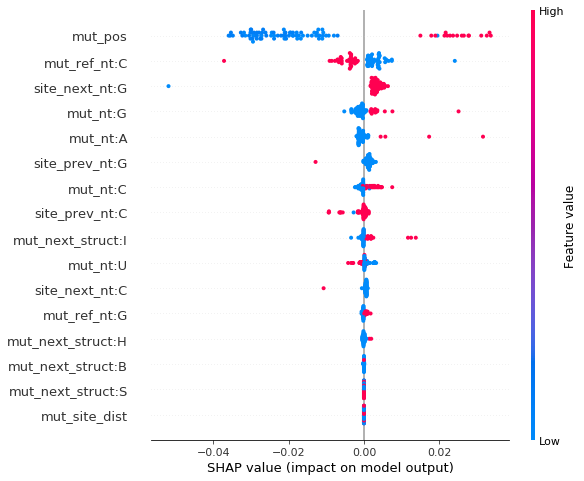

Contribution/Total:0.17048538
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_c

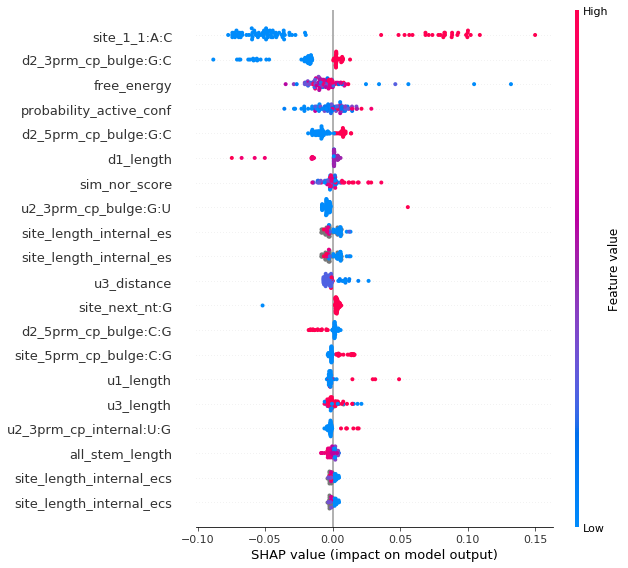

Contribution/Total:0.8729947
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*']


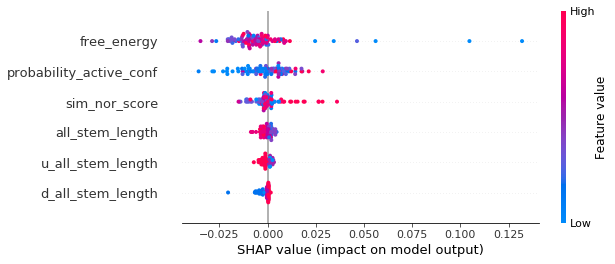

Contribution/Total:0.1354505


In [54]:
from feature_subsets import * 
subset_names=["sub_site_seq","biophysical","u1_d1","mut","site","u","d","u_d","mut_site","no_up","no_down","site_struct","site_seq","mut_seq","mut_seq_site","no_mut","overall_structure"]
subset_contribs=[]
for subset in [sub_site_seq,biophysical,u1_d1,mut,site,u,d,u_d,mut_site,no_up,no_down,site_struct,site_seq,mut_seq,mut_seq_site,no_mut,overall_structure]: 
  print(subset)
  cur_features=filter_features(shap_values,subset)
  cur_feature_shap=shap_values[cur_features].values 
  cur_feature_data_X=test_X[cur_features]
  shap.summary_plot(cur_feature_shap, cur_feature_data_X)#,sort=False,max_display=50)
  contrib=shap_contribs_subgroup(shap_values,subset)
  subset_contribs.append(contrib)
  print("Contribution/Total:"+str(contrib))

In [55]:
subset_contrib_df=pd.DataFrame({'Subset':subset_names,
                               'Contribution':[100*i for i in subset_contribs]})

In [56]:
subset_contrib_df

Subset  Contribution
0        sub_site_seq      2.909597
1         biophysical     11.178501
2               u1_d1      4.661612
3                 mut     21.554059
4                site     37.566367
5                   u     12.295596
6                   d     23.892452
7                 u_d     36.188048
8            mut_site     59.120429
9               no_up     96.557933
10            no_down     84.961075
11        site_struct     34.656775
12           site_seq      2.909597
13            mut_seq     14.138940
14       mut_seq_site     17.048538
15             no_mut     87.299472
16  overall_structure     13.545050

In [57]:
subset_contrib_df=subset_contrib_df.sort_values(by=['Contribution'],ascending=False)
subset_contrib_df.reset_index(inplace=True, drop=True) 

In [58]:
from pandas.api.types import CategoricalDtype

In [59]:
subset_cat = CategoricalDtype(categories=list(subset_contrib_df['Subset']), ordered=True)

# Cast the existing categories into the new category. Due to a bug in pandas
# we need to do this via a string.
subset_contrib_df['Subset_Cat'] = subset_contrib_df['Subset'].astype(str).astype(subset_cat)


In [60]:
subset_contrib_df

Subset  Contribution         Subset_Cat
0               no_up     96.557933              no_up
1              no_mut     87.299472             no_mut
2             no_down     84.961075            no_down
3            mut_site     59.120429           mut_site
4                site     37.566367               site
5                 u_d     36.188048                u_d
6         site_struct     34.656775        site_struct
7                   d     23.892452                  d
8                 mut     21.554059                mut
9        mut_seq_site     17.048538       mut_seq_site
10            mut_seq     14.138940            mut_seq
11  overall_structure     13.545050  overall_structure
12                  u     12.295596                  u
13        biophysical     11.178501        biophysical
14              u1_d1      4.661612              u1_d1
15           site_seq      2.909597           site_seq
16       sub_site_seq      2.909597       sub_site_seq

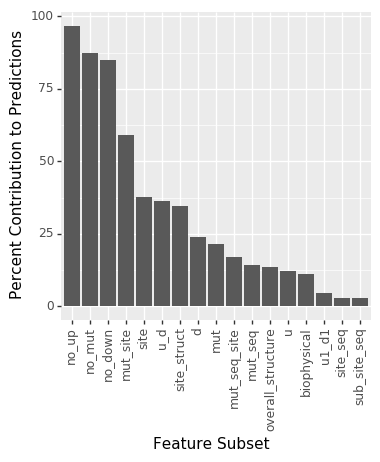

<ggplot: (8765716438673)>

In [61]:
p=(ggplot(subset_contrib_df, aes('Subset_Cat', 'Contribution'))
 + geom_bar(stat='identity')
 + xlab("Feature Subset")
 + ylab("Percent Contribution to Predictions")
 + theme(axis_text_x=element_text(angle=90))
)
ggsave(plot=p, filename='TTYH2.comp.subset.importance.svg',width=5,height=4,units='in')
p

## No "mut" features

In [62]:
## Read in the data 
import pandas as pd 
import feature_subsets
data=pd.read_csv("../xin_feature_matrices/ttyh2_computational.features.csv",header=0,sep=',',index_col=0)
#drop all mut features
cur_features=filter_features(data,feature_subsets.mut)
cur_features.remove('mut_pos')
data=data.drop(cur_features,axis=1)
data.head

<bound method NDFrame.head of                  editing_value  free_energy  sim_nor_score  \
rna_id                                                       
TTYH_BC_000             0.3060       -87.05         1.0000   
TTYH_BC_001             0.2755       -80.48         0.9011   
TTYH_BC_002             0.3245       -80.17         0.9037   
TTYH_BC_003             0.3885       -80.78         0.9866   
TTYH_BC_004             0.2045       -86.11         0.9054   
...                        ...          ...            ...   
TTYH_ECS_BC_171         0.0340       -83.59         0.9933   
TTYH_ECS_BC_171         0.0340       -83.59         0.9933   
TTYH_ECS_BC_172         0.0400       -85.94         0.8571   
TTYH_ECS_BC_172         0.0400       -85.94         0.8571   
TTYH_ECS_BC_172         0.0400       -85.94         0.8571   

                 probability_active_conf  mut_exist  mut_type  mut_pos  \
rna_id                                                                   
TTYH_BC_000    

In [63]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [64]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(601, 178)
{21.0: 18, 22.0: 18, 23.0: 18, 24.0: 20, 25.0: 17, 26.0: 20, 27.0: 20, 28.0: 20, 29.0: 18, 30.0: 18, 31.0: 17, 32.0: 17, 33.0: 17, 34.0: 18, 35.0: 18, 36.0: 18, 79.0: 17, 80.0: 17, 81.0: 18, 82.0: 18, 83.0: 19, 84.0: 19, 85.0: 20, 86.0: 29, 88.0: 27, 89.0: 18, 90.0: 17, 91.0: 17, 92.0: 17, 93.0: 14, 94.0: 18, 95.0: 18, nan: 0, nan: 0, nan: 0, nan: 0, nan: 6}


In [65]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [66]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [67]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
to_drop.append("mut_pos")
print("\n".join(to_drop))

site_3prm_cp_bulge:C:G
site_5prm_cp_internal:G:C
d3_length_internal_ecs
u2_3prm_cp_internal:A:U
d1_length_internal_ecs
site_next_nt:A
d1_length_bulge
d2_5prm_cp_internal:U:G
d3_length_internal_es
site_prev_nt:A
u2_5prm_cp_bulge:G:U
site_next_nt:U
d3_5prm_cp_hairpin
d2_3prm_cp_bulge:G:U
u1_3prm_cp_internal:G:U
u1_length_hairpin
u3_length_bulge
u2_3prm_cp_bulge:U:G
site_5prm_cp_bulge:U:G
u_hairpin_length
mut_type:mismatch
d1_length_internal_es
mut_exist
u2_5prm_cp_internal:C:G
d3_3prm_cp_internal
d3_5prm_cp_internal
d1_struct:I
site_length_hairpin
u2_3prm_cp_bulge:G:C
d2_5prm_cp_bulge:A:U
d2_length_stem
u1_struct:I
u1_5prm_cp_hairpin
site_next_struct:I
d3_3prm_cp_bulge:G:C
u3_length_internal_es
u3_5prm_cp_internal
d1_5prm_cp_bulge
site_5prm_cp_hairpin
u1_length_bulge
u2_3prm_cp_internal:U:A
d1_5prm_cp_internal:C:G
d3_length_hairpin
u3_3prm_cp_internal
u1_5prm_cp_internal:U:A
mut_type:wt
u1_length_internal_ecs
d1_3prm_cp_bulge
d2_struct:S
d3_struct:B
site_3prm_cp_internal:A:U
u1_distance


In [68]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [69]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [70]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(408, 91)
(408,)
(91, 91)
(91,)
(108, 91)
(108,)


In [71]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [72]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [73]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [74]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.68720	eval-mae:0.21184	eval-map:1.00000	eval-aucpr:0.31595	eval-rmse:0.24268	train-auc:0.68712	train-mae:0.24472	train-map:1.00000	train-aucpr:0.26740	train-rmse:0.26258
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.71465	eval-mae:0.15422	eval-map:1.00000	eval-aucpr:0.33354	eval-rmse:0.17802	train-auc:0.72039	train-mae:0.17468	train-map:1.00000	train-aucpr:0.29223	train-rmse:0.19117
[2]	eval-auc:0.72322	eval-mae:0.11669	eval-map:1.00000	eval-aucpr:0.35318	eval-rmse:0.13634	train-auc:0.73566	train-mae:0.12652	train-map:1.00000	train-aucpr:0.30972	train-rmse:0.14106
[3]	eval-auc:0.72849	eval-mae:0.09647	eval-map:1.00000	eval-aucpr:0.35585	eval-rmse:0.11374	train-auc:0.73997	train-mae:0.09478	train-map:1.00000	train-aucpr:0.31075	train-rmse:0.10735
[4]	eval-auc:0.73147	eval-mae:0.08380	eval-map:1.00000	eval-aucpr:0.36021	eval-rmse:0.10207	train-auc:0.74376	train

[44]	eval-auc:0.74276	eval-mae:0.04484	eval-map:1.00000	eval-aucpr:0.36326	eval-rmse:0.08582	train-auc:0.76275	train-mae:0.00484	train-map:1.00000	train-aucpr:0.33660	train-rmse:0.00806
[45]	eval-auc:0.74286	eval-mae:0.04484	eval-map:1.00000	eval-aucpr:0.36330	eval-rmse:0.08579	train-auc:0.76278	train-mae:0.00471	train-map:1.00000	train-aucpr:0.33667	train-rmse:0.00771
[46]	eval-auc:0.74267	eval-mae:0.04480	eval-map:1.00000	eval-aucpr:0.36313	eval-rmse:0.08586	train-auc:0.76280	train-mae:0.00458	train-map:1.00000	train-aucpr:0.33670	train-rmse:0.00740
[47]	eval-auc:0.74274	eval-mae:0.04463	eval-map:1.00000	eval-aucpr:0.36328	eval-rmse:0.08588	train-auc:0.76284	train-mae:0.00435	train-map:1.00000	train-aucpr:0.33674	train-rmse:0.00710
[48]	eval-auc:0.74263	eval-mae:0.04448	eval-map:1.00000	eval-aucpr:0.36218	eval-rmse:0.08579	train-auc:0.76285	train-mae:0.00422	train-map:1.00000	train-aucpr:0.33677	train-rmse:0.00682
[49]	eval-auc:0.74251	eval-mae:0.04420	eval-map:1.00000	eval-aucpr:0.3

[89]	eval-auc:0.74287	eval-mae:0.04207	eval-map:1.00000	eval-aucpr:0.36314	eval-rmse:0.08524	train-auc:0.76314	train-mae:0.00113	train-map:1.00000	train-aucpr:0.33709	train-rmse:0.00202
[90]	eval-auc:0.74287	eval-mae:0.04205	eval-map:1.00000	eval-aucpr:0.36314	eval-rmse:0.08525	train-auc:0.76314	train-mae:0.00110	train-map:1.00000	train-aucpr:0.33709	train-rmse:0.00198
[91]	eval-auc:0.74287	eval-mae:0.04205	eval-map:1.00000	eval-aucpr:0.36314	eval-rmse:0.08526	train-auc:0.76314	train-mae:0.00108	train-map:1.00000	train-aucpr:0.33709	train-rmse:0.00196
[92]	eval-auc:0.74287	eval-mae:0.04205	eval-map:1.00000	eval-aucpr:0.36314	eval-rmse:0.08528	train-auc:0.76314	train-mae:0.00106	train-map:1.00000	train-aucpr:0.33709	train-rmse:0.00193
[93]	eval-auc:0.74287	eval-mae:0.04204	eval-map:1.00000	eval-aucpr:0.36314	eval-rmse:0.08528	train-auc:0.76315	train-mae:0.00105	train-map:1.00000	train-aucpr:0.33709	train-rmse:0.00193
[94]	eval-auc:0.74287	eval-mae:0.04204	eval-map:1.00000	eval-aucpr:0.3

In [75]:
# save to binary file for faster loading
bst.save_model('neil1.computational.model')
# save model to text file 
bst.dump_model('neil1.computational.raw.txt')


In [76]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [77]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.999768535815952, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.8838292738914976, pvalue=4.11605840683651e-31)
Test:SpearmanrResult(correlation=0.9373529081908938, pvalue=2.3638376843408385e-50)


Pearson correlation:
Train:(0.9998844592539067, 0.0)
Eval:(0.8589128895394901, 1.3323215551130348e-27)
Test:(0.8967902775849224, 2.493529303852695e-39)


In [78]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0010509618106414424
MAE Eval:0.04203743972969088
MAE Test:0.025275197373496157


In [79]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:1.1487146267194055%
MAPE Eval:27.00383106869285%
MAPE Test:32.27285496887639%


In [80]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0019285512357771763
RMSE Eval:0.08527899631672031
RMSE Test:0.05696040760358439


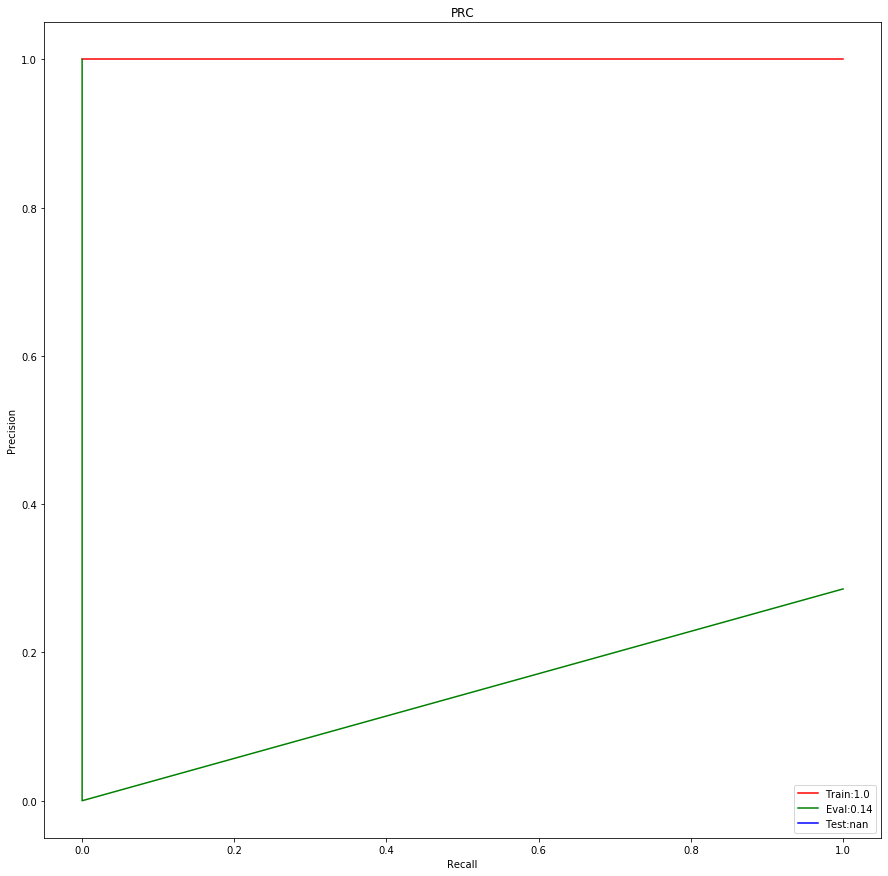

In [81]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.5,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.5,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.5,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

In [82]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.5,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.5,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.5,test_pred)

auroc_train=roc_auc_score(train_y>=0.5,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.5,eval_pred)
auroc_test=roc_auc_score(test_y>=0.5,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

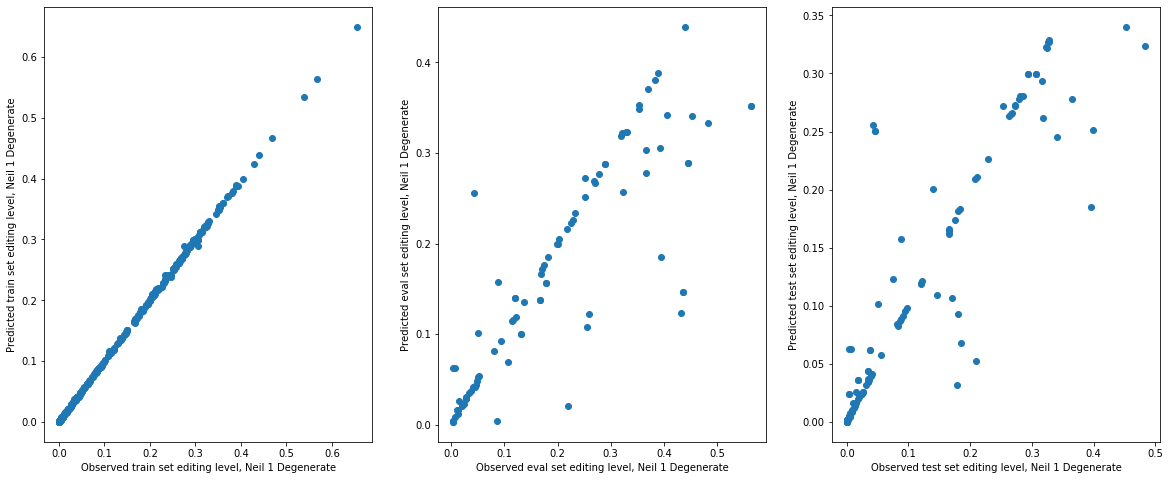

In [83]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

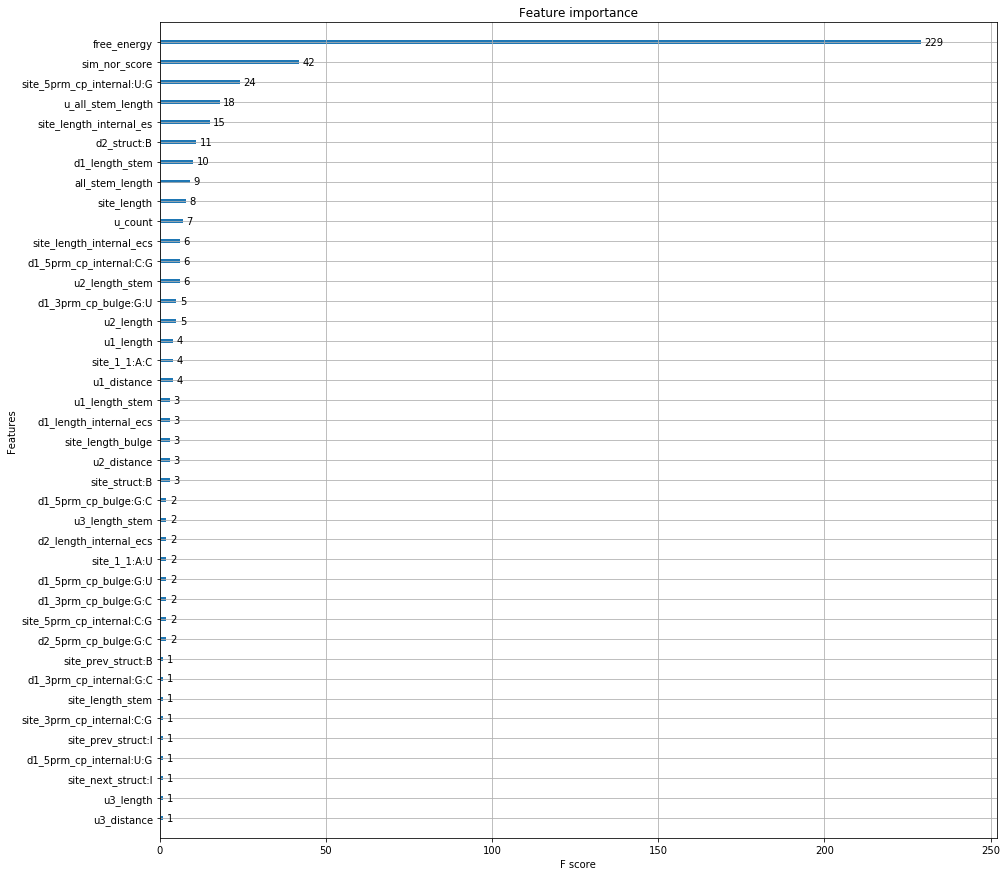

In [115]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

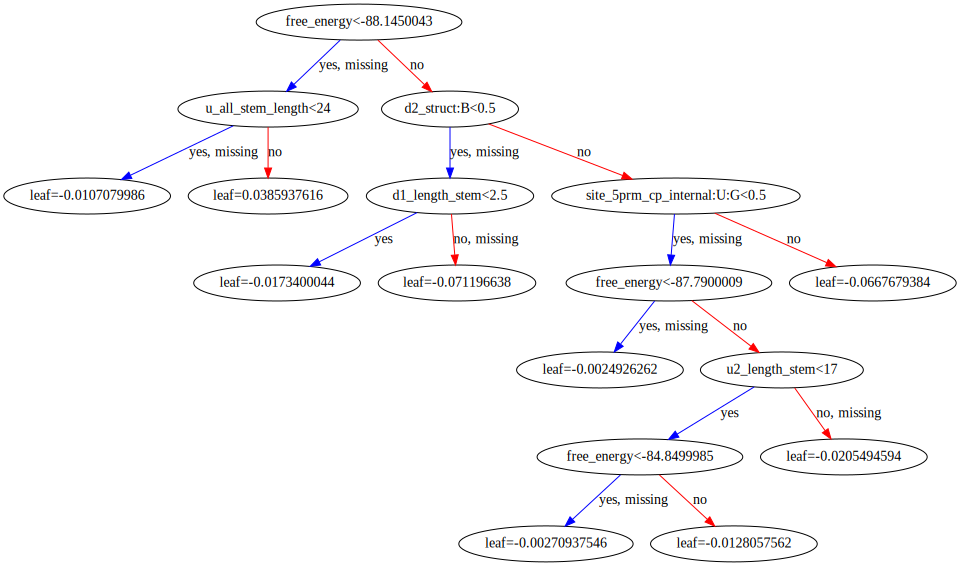

In [116]:
xgboost.to_graphviz(bst, num_trees=2)


In [84]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(108, 91)

In [85]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [86]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [87]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

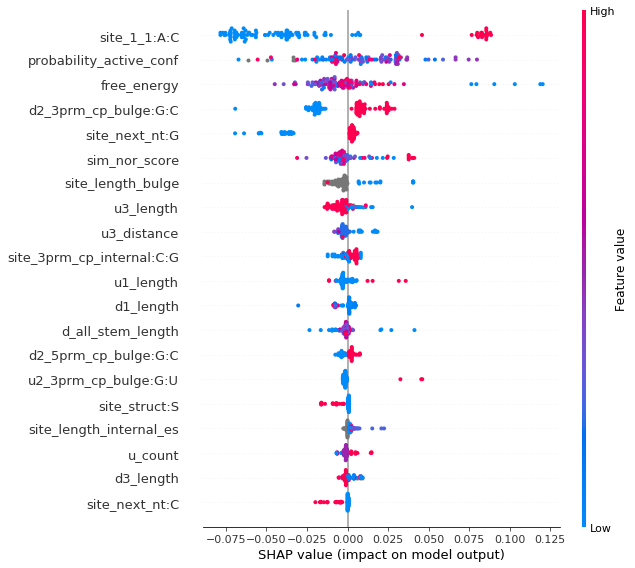

In [88]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


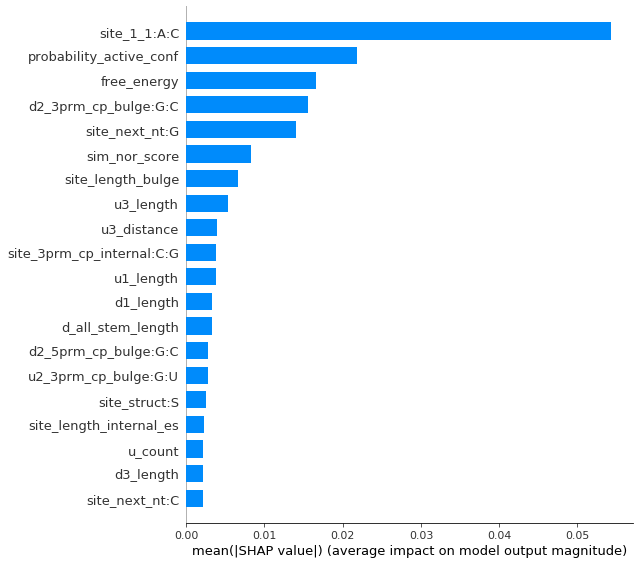

In [89]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [90]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(108, 91, 91)

In [91]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [92]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [93]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)
